In [462]:
try:    importlib.reload(Jupytils)
except: import Jupytils
showTopbar("Crystal Ball Examples", menu=[("Help", "#"), ("Home", "#")])

import pymc3 as pymc3
from pymc3 import *
from numpy import median
from scipy import optimize
import openpyxl

<IPython.core.display.Javascript object>

In [463]:
df2 = pd.read_excel(fileName, header=None, sheetname=sheetname)
colNames = [openpyxl.utils.get_column_letter(c) for c in range(1,df2.shape[1]+1) ]
df2.columns = (colNames)

df2.fillna('', inplace=True)
df2.index = range(len(df2))
wb = openpyxl.load_workbook(fileName)
if ( type(sheetname) == int):
    sheetname = wb.sheetnames[sheetname]
ws=wb[sheetname]
df2.formulas = getFormulas(ws, df2)

In [507]:
#********** DO NOT USE THIS IF ALL THE TABLE CONTENTS ARE NOT SHOWING
#
cellJAVASCRIPT='''
v2 = $('{}_searchResults')

td = $('{} tr').eq({}).find('td').eq({});
//console.log(r, c,td.text())
td.attr('title', '{}')
td.css('background-color', '{}')
td.css('border', '2px {} solid')
td.css('background-image', 'url(nnormal.png)')
td.css('background-size', '80px')
td.css('background-repeat', 'no-repeat')
td.focusin (function(){{
    v2.text($(this).attr('title'))
//    console.log('sadass')
}});
'''
def getOurCodedCells(df2):
    detrs = {}
    probs = {}
    for i, r in df2.iterrows():
        cc= -1;
        for j, c in r.iteritems():
            c = str(c).strip()
            cc += 1;
            if ( c.startswith('::PROB::') ):
                probs[(i+1, cc+1)] = c;
            elif ( c.startswith('::DETR::') ):
                detrs[(i+1, cc+1)] = c;
    return probs, detrs


def setCellFormat(df2, dictItems={}, background='', border='blue'):
    scr = "<script>\n"
    tableID = "#"+ df2.tableID
    for k, f in dictItems.items(): 
        c1, c2 = k
        ff = f.replace("'", r"\'")
        scr += cellJAVASCRIPT.format(tableID,tableID, c1,c2-1,ff, background, border)
    scr+="</script>\n"

    display(HTML(scr))
    
def HighlightDF(df2):
    probs, detrs = getOurCodedCells(df2)
    
    setCellFormat(df2, df2.formulas,'', 'blue')
    setCellFormat(df2, probs,'', 'green')
    setCellFormat(df2, detrs,'', 'cyan')
    return probs, detrs, df2.formulas
    
def showExcelDF(df2):
    if (len(df2) > 500):
        return "Max Rows Exceeded"
    displayDFs(df2, showIcons=False, maxrows=len(df2));

    probs, detrs, df2.formulas = HighlightDF(df2)
    return probs, detrs, df2.formulas



In [508]:
fileName="Examples/Cell Phone.xlsx"; sheetname='Model'
#fileName="nogit/lrp/fin.xlsx";sheetname='Crystal Ball Model'
df2= LoadDataSet(fileName, sheetname=sheetname)
p,d,f = showExcelDF(df2)

,A,B,C,D,E,F,G,H,I
0,,Deciding on a Monthly Cell Phone Plan,,,,,,,Learn about model
1,,,,,,,,,
2,,,Cellular World,Freedom Cell,,,,,"::PROB::D11::Normal::{mu: 400, sd:20}"
3,,Base Fee,39.990,35,,,,,"::PROB::D12::Triangular::l::{1:.1, h:.4,m:.3}"
4,,Included Minutes,400,Unlimited,,,,,::DETR::D14::ROIFunction()
5,,Additional Minutes,0.400,0,,,,,
6,,Long Distance,0,0.080,,,,,
7,,Total Cost,39.990,44.600,,,,,
8,,,,,,Assumption parameters,,,
9,,,,Assumptions,,Parm 1,Parm 2,Parm 3,Distribution


In [509]:
tableID = "#"+ df2.tableID
tdh=r'''
<h3>Add Assumptions:</h3>
<div style="border-bottom: 1px #dddddd solid;"/>
Cell/Variable: <input type="text" id="assump">
<iimg src="normal.png" width="96px">
<br/>
<select id="listass" size="10" style="height:100pxß;">
    <option value=""></option>
    <option value="Normal(\'Name\', mu=0, sd=0 )">Normal(\'Name\', mu=0, sd=0 ) <img src="normal.png"> > <img src="normal.png"> </option>
    <option value="Triangular(\'Name\', l=.1, h=.5,max=.7 )">Triangular(\'Name\', l=.1, h=.5,max=.7 )</option>
</select><br/>

</script>
<script>
$("#proexample").on("change",function() {{
    var v = this.value;
    if (v=="") return; 

    $('#protext').val(v); 
  }}); 
</script>  
'''

display(HTML(tdh))


In [683]:
def genCB(v, rent=500):
    return v['Number Of Units'] * rent - v['Operating Cost']

N={}
with pymc3.Model() as mcmc:
    pymc3.Uniform('Number Of Units', 30, 40);
    pymc3.Normal('Operating Cost', mu=15000, sd=1000 );
    pymc3.Tri('Operating Cost', mu=15000, sd=1000 );
    
    for c in mcmc.unobserved_RVs:
        N[str(c)] = c
        
    ROI = Deterministic('ROI', genCB(N) )
    
    #print(mcmc.deterministics)
    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)
    # instantiate sampler
    step = NUTS(scaling=start)
    # draw 2000 posterior samples
    
    #==>traced = sample(10000, step, start=start)
    traced = sample(1000, step, start=start)


[Number Of Units, ROI]
Optimization terminated successfully.
         Current function value: 9.212988
         Iterations: 1
         Function evaluations: 31


100%|██████████| 1000/1000 [00:01<00:00, 735.99it/s]


2528.22883937 1695.22638203


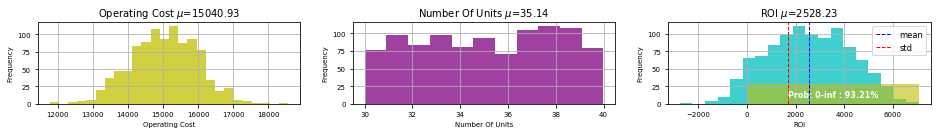

In [695]:
from theano.tensor.var import TensorVariable

plt.figure(figsize=(16,1.5))
facecolor='y,purple,c,blue,green,red'.split(',')
vars = [v for v in traced.varnames if not v.endswith('_')]
dets = []
for m in mcmc.deterministics:
    s = str(m)
    if (type(m)) == TensorVariable and not s.endswith('_'):
        vars.remove(s)
        dets.append(s)
n=len(vars)
r = int(np.ceil(n/10)) ; # plots per line
c=min(n+1, 6)

for i,j in enumerate(vars):
    if j.endswith('_'): continue;
    
    aj = np.mean(traced[j])
    subplot= "{}{}{}".format(r,c,i+1)
    plthist(traced[j], title='{} $\mu$={:.2f}'.format(j,aj), ylabel='Frequency', xlabel=j, facecolor=facecolor[i%len(facecolor)], subplot=int(subplot));

i += 1;
for j,k in enumerate(dets):
    aj = np.mean(traced[k])
    subplot= "{}{}{}".format(r,c,i+j+1)
    plthist(traced[k], title='{} $\mu$={:.2f}'.format(k,aj), ylabel='Frequency', xlabel=k, facecolor=facecolor[(i+j)%len(facecolor)], subplot=int(subplot), ablines=['mean', 'std'], legend=True, low=0, high=np.math.inf);



In [696]:
#from pymc3 import traceplot
#traceplot(traced);